In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import pandas as pd
from InverseFuncs import trajectory, getLoss, reset_theta, theta_range

from DDPGv2Agent import Agent
from FireflyEnv import Model # firefly_task.py
from collections import deque
from Inverse_Config import Inverse_Config
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# read configuration parameters
arg = Inverse_Config()

# fix random seed
import random
random.seed(arg.SEED_NUMBER)
import torch
torch.manual_seed(arg.SEED_NUMBER)
if torch.cuda.is_available():
    torch.cuda.manual_seed(arg.SEED_NUMBER)
import numpy as np
np.random.seed(arg.SEED_NUMBER)
import time

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()
print("{} cores are available".format(num_cores))

# if gpu is to be used
#CUDA = False
#device = "cpu"

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tic = time.time()



filename = '20191231-172726-01081157' # agent information

learning_arg = torch.load('../firefly-inverse-data/data/20191231-172726_arg.pkl')

DISCOUNT_FACTOR = learning_arg.DISCOUNT_FACTOR
arg.gains_range = learning_arg.gains_range
arg.std_range = learning_arg.std_range
arg.goal_radius_range = learning_arg.goal_radius_range
arg.WORLD_SIZE = learning_arg.WORLD_SIZE
arg.DELTA_T = learning_arg.DELTA_T
arg.EPISODE_TIME = learning_arg.EPISODE_TIME
arg.EPISODE_LEN = learning_arg.EPISODE_LEN
arg.PI_STD = 0.1
arg.NUM_EP = 200
arg.NUM_SAMPLES = 5


env = Model(arg) # build an environment
env.max_goal_radius = arg.goal_radius_range[1] # use the largest world size for goal radius
env.box = arg.WORLD_SIZE
agent = Agent(env.state_dim, env.action_dim, arg,  filename, hidden_dim=128, gamma=DISCOUNT_FACTOR, tau=0.001) #, device = "cpu")
agent.load(filename)


12 cores are available
Running DDPG Agent: using  cpu


In [2]:
arg.PI_STD

0.1

In [3]:
def loss_cal(vel, pro_gains_vel, gain_space, true_theta):
    
    loss_log = torch.zeros(len(gain_space)+1)
    pro_gains = torch.zeros(2)
    pro_noise_stds = torch.zeros(2)
    obs_gains = torch.zeros(2)
    obs_noise_stds = torch.zeros(2)
    goal_radius = torch.zeros(1)
    
    theta_log = []
    inputs_ang = np.sort(np.append(gain_space, true_theta[1]))

    pro_gains[0] = pro_gains_vel
    for ang, pro_gains_ang in enumerate(tqdm(inputs_ang)):
        pro_gains[1] = pro_gains_ang
        for obs_gains_vel  in [true_theta[4]]:#np.append(gain_space, true_theta[4]):
            obs_gains[0] = obs_gains_vel
            for obs_gains_ang in [true_theta[5]]:#np.append(gain_space, true_theta[5]):
                obs_gains[1] = obs_gains_ang
                for pro_std_vel in [true_theta[2]]:#np.append(std_space, true_theta[2]):
                    pro_noise_stds[0] = pro_std_vel
                    for pro_std_ang in [true_theta[3]]:#np.append(std_space, true_theta[3]):
                        pro_noise_stds[1] = pro_std_ang
                        for obs_std_vel in [true_theta[6]]:#np.append(std_space, true_theta[6]):
                            obs_noise_stds[0] = obs_std_vel 
                            for obs_std_ang in [true_theta[7]]:#np.append(std_space, true_theta[7]):
                                obs_noise_stds[1] = obs_std_ang
                                for goal_r in [true_theta[8]]: #np.append(goal_radius_space, true_theta[8]):
                                    goal_radius[0] = goal_r
                                    
                                    
                                    theta = torch.cat([pro_gains, pro_noise_stds, obs_gains, obs_noise_stds, goal_radius])
    
    
                                    theta_log.append(theta.data)
                                    loss = getLoss(agent, x_traj, a_traj, theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)
                                    loss_log[ang] = loss.data
                                    #loss_log.append(loss.data)

                                    print("num:{}, theta:{}, loss:{}".format(vel, theta, loss))
                        
                        
    """
    result = {'true_theta': true_theta,
         'true_loss': true_loss,
         'theta_log': theta_log,
         'loss_log': loss_log}
    """
    return loss_log


In [4]:
# true theta
#true_theta = reset_theta(arg.gains_range, arg.std_range, arg.goal_radius_range)
#true_theta[0]=11.5
#true_theta[1]=11.5
true_theta=torch.tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,0.2809])


x_traj, obs_traj, a_traj, _ = trajectory(agent, true_theta, env, arg, arg.gains_range, arg.std_range,arg.goal_radius_range, arg.NUM_EP)  # generate true trajectory
true_loss = getLoss(agent, x_traj, a_traj, true_theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)  # this is the lower bound of loss?
print("true loss:{}".format(true_loss))
print("true_theta:{}".format(true_theta))

current_theta = true_theta

true loss:45588.859375
true_theta:tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])


In [5]:
current_theta=torch.tensor([1.1317e+01, 9.4682e+00, 1.0000e-02, 2.5650e-02, 8.4879e+00, 1.1435e+01,
        1.7711,  0.1619, 2.7555e-01])

In [6]:
gain_space = np.linspace(arg.gains_range[0],arg.gains_range[1], num = 9)
std_space = np.linspace(arg.std_range[0], arg.std_range[1], num = 3)
goal_radius_space = np.linspace(arg.goal_radius_range[0], arg.goal_radius_range[1], num =3)

In [7]:
gain_space

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ])

In [8]:
true_theta


tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [9]:
inputs_vel = np.sort(np.append(gain_space, true_theta[0]))
inputs_ang = np.sort(np.append(gain_space, true_theta[1]))

#loss_log = torch.zeros([len(gain_space)+1, len(gain_space)+1])
loss_log = Parallel(n_jobs=num_cores)(delayed(loss_cal)(vel, pro_gains_vel, gain_space, current_theta) for vel, pro_gains_vel in enumerate(inputs_vel))


In [10]:
loss_log
    

[tensor([99227.5703, 97728.1562, 96961.0781, 97112.0078, 97006.9688, 97301.0000,
         97270.1250, 99462.7344, 99176.2031, 99892.3750]),
 tensor([91748.9062, 91350.2500, 89835.4375, 91127.4375, 91191.3125, 91402.4688,
         91836.7109, 91700.8047, 93784.1484, 94358.1797]),
 tensor([78879.4453, 80440.0625, 81317.3984, 82747.2109, 82844.7422, 80436.2891,
         82724.9141, 83730.5781, 84596.7812, 85337.3516]),
 tensor([70401.3672, 71507.0312, 69044.8906, 68991.3203, 68976.7891, 71233.1875,
         72539.4844, 72491.0859, 76060.0312, 78389.8359]),
 tensor([58536.1758, 58843.3711, 57003.0508, 57935.0195, 58144.2148, 60761.9805,
         64553.7695, 68472.4609, 71296.4922, 73520.8906]),
 tensor([45323.3203, 48284.6758, 52346.4453, 51894.1523, 52273.8359, 55437.2266,
         57505.7070, 61823.1680, 64306.9648, 69056.2578]),
 tensor([39878.8945, 43411.6719, 45014.4336, 46878.6094, 46983.8438, 50870.8047,
         54391.2773, 59124.0703, 62066.8594, 68187.7109]),
 tensor([39143.5430,

In [11]:
loss_log_tot = torch.cat([loss_log[i] for i in range (len(loss_log))])

In [12]:
loss_log_tot

tensor([99227.5703, 97728.1562, 96961.0781, 97112.0078, 97006.9688, 97301.0000,
        97270.1250, 99462.7344, 99176.2031, 99892.3750, 91748.9062, 91350.2500,
        89835.4375, 91127.4375, 91191.3125, 91402.4688, 91836.7109, 91700.8047,
        93784.1484, 94358.1797, 78879.4453, 80440.0625, 81317.3984, 82747.2109,
        82844.7422, 80436.2891, 82724.9141, 83730.5781, 84596.7812, 85337.3516,
        70401.3672, 71507.0312, 69044.8906, 68991.3203, 68976.7891, 71233.1875,
        72539.4844, 72491.0859, 76060.0312, 78389.8359, 58536.1758, 58843.3711,
        57003.0508, 57935.0195, 58144.2148, 60761.9805, 64553.7695, 68472.4609,
        71296.4922, 73520.8906, 45323.3203, 48284.6758, 52346.4453, 51894.1523,
        52273.8359, 55437.2266, 57505.7070, 61823.1680, 64306.9648, 69056.2578,
        39878.8945, 43411.6719, 45014.4336, 46878.6094, 46983.8438, 50870.8047,
        54391.2773, 59124.0703, 62066.8594, 68187.7109, 39143.5430, 41322.6328,
        46450.3242, 46804.7852, 47041.44

In [13]:
true_theta

tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [14]:
dx, dy = 0.25, 0.25
new_gain_space = np.append(gain_space, gain_space.max()+0.5)

pinputs_vel = np.sort(np.append(new_gain_space, true_theta[0]))
pinputs_ang = np.sort(np.append(new_gain_space, true_theta[1]))
x,y = np.meshgrid( pinputs_ang-dy, pinputs_vel-dx)
Z = loss_log_tot

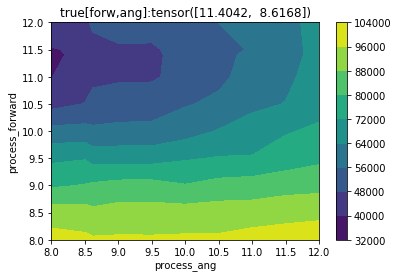

In [15]:
plt.contourf(inputs_ang, inputs_vel,Z.view(len(inputs_vel), len(inputs_ang)))  
plt.xlabel('process_ang')
plt.ylabel('process_forward')
plt.title('true[forw,ang]:{}'.format(true_theta[:2].data))
plt.colorbar()

Text(0.5, 1.0, 'true[forw,ang]:tensor([11.4042,  8.6168])')

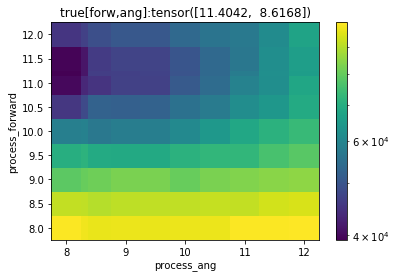

In [16]:

plt.pcolor(x, y, Z.view(len(inputs_vel), len(inputs_ang)), norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.colorbar()
plt.xlabel('process_ang')
plt.ylabel('process_forward')
plt.title('true[forw,ang]:{}'.format(true_theta[:2].data))

In [17]:
torch.save(loss_log, '../firefly-inverse-data/data/'+filename+'loss_plotter.pkl')